In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [34]:
trainData = pd.read_csv("CustomLocationTrain.csv")
testData = pd.read_csv("CustomLocationTest.csv")

feature = 'HLY-PRES-NORMAL'

trainData['DATE'] = pd.to_datetime(trainData['DATE'], format='%Y-%m-%d %H:%M:%S')
testData['DATE'] = pd.to_datetime(testData['DATE'], format='%Y-%m-%d %H:%M:%S')
#note: first observation is missing
trainData = trainData.loc[1:]
testData = testData.loc[1:]
trainData=trainData[['DATE', feature]]
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 1 to 936
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             936 non-null    datetime64[ns]
 1   HLY-PRES-NORMAL  936 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.8 KB


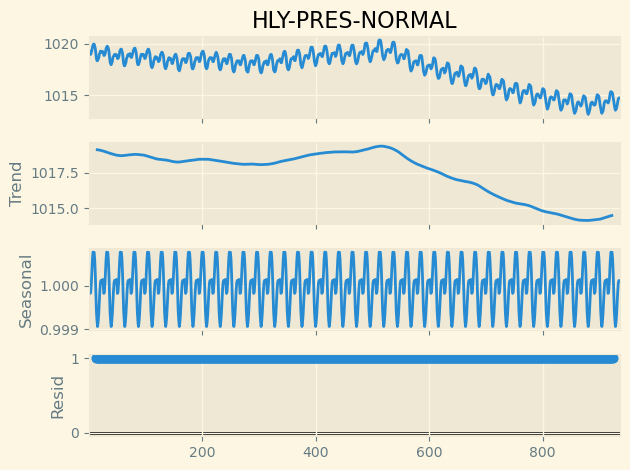

In [35]:
#Beginning with testing holt winters exponential smoothing

#check if data is multiplicitive
decomp_mult = seasonal_decompose(trainData[feature], model='multiplicative', period=24)
decomp_mult.plot()
plt.show()

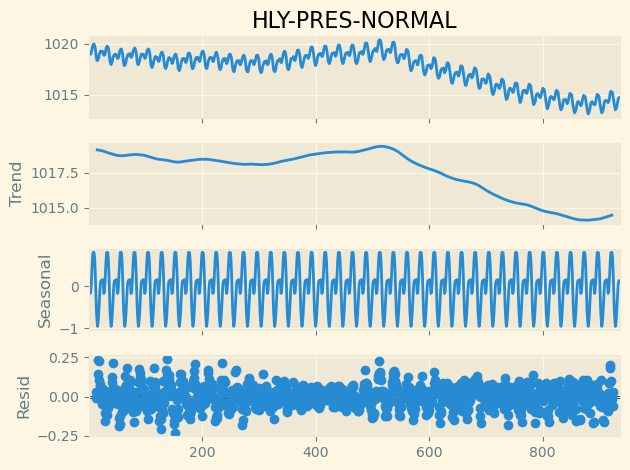

In [36]:
#check if data is additive
decomp_add = seasonal_decompose(trainData[feature], model='additive', period=24)
decomp_add.plot()
plt.show()

C:\Users\PeplinskiMatthew\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


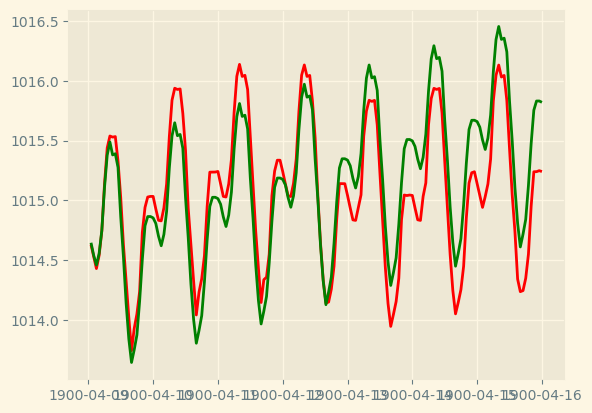

0.30747312259437837


In [37]:
#based on data, most of our data has additive for seasonality and trend and has a 24 hour daily cycle
holt_wint_model = ExponentialSmoothing(trainData[feature] ,seasonal_periods=24, seasonal="add", trend="add", dates=trainData['DATE']).fit()
holt_wint_forecast = holt_wint_model.forecast(testData.DATE.nunique())

#plt.plot(trainData['DATE'], trainData[feature], c="blue")
plt.plot(testData['DATE'], testData[feature], c="red")
plt.plot(testData['DATE'], holt_wint_forecast, c="green")
plt.show()

rmse = root_mean_squared_error(testData[feature], holt_wint_forecast)
print(rmse)

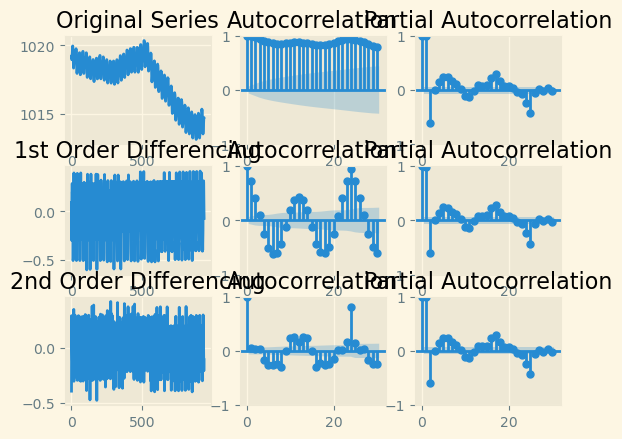

ADF Statistic for 1st Order Differencing
ADF Statistic: -23.342339
p-value: 0.000000

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -27.336348
p-value: 0.000000


In [38]:
# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(trainData[feature]); axes[0, 0].set_title('Original Series')
plot_acf(trainData[feature], ax=axes[0, 1])
plot_pacf(trainData[feature], ax=axes[0, 2], method='ywm')

# 1st Differencing
axes[1, 0].plot(trainData[feature].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(trainData[feature].diff().dropna(), ax=axes[1, 1])
plot_pacf(trainData[feature], ax=axes[1, 2], method='ywm')

# 2nd Differencing
axes[2, 0].plot(trainData[feature].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(trainData[feature].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(trainData[feature], ax=axes[2, 2], method='ywm')

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(trainData[feature].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(trainData[feature].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


C:\Users\PeplinskiMatthew\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


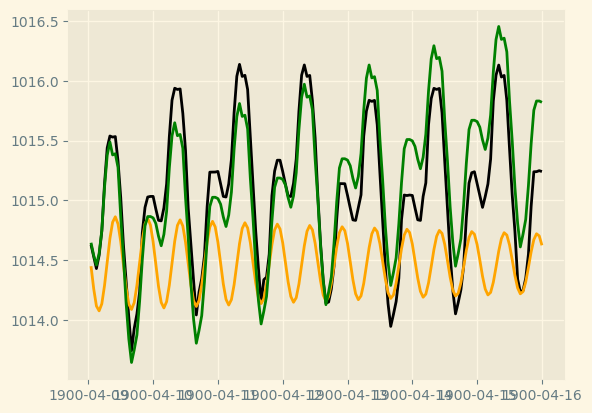

In [43]:
model2 = ARIMA(trainData[feature], order=(3,1,5)).fit()
forecasts_base = model2.forecast(len(testData))
plt.style.use("Solarize_Light2")
#plt.plot(trainData['DATE'], trainData[feature], c="blue")
plt.plot(testData['DATE'], testData[feature], c="black")
plt.plot(testData['DATE'], forecasts_base, c="orange")
plt.plot(testData['DATE'], holt_wint_forecast, c="green")
plt.show()

#check residual sum of squares
score = root_mean_squared_error(testData[feature], forecasts_base)
print(score)

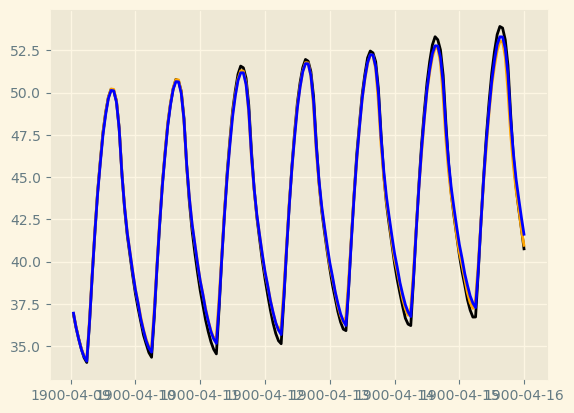

In [31]:
#model = ARIMA(trainData[feature], order=(15,1,12), seasonal_order = (1,1,2,24)).fit()
#forecasts_seasonal = model.forecast(len(testData))

#plt.plot(trainData['DATE'], trainData[feature], c="blue")
plt.plot(testData['DATE'], testData[feature], c="black")
plt.plot(testData['DATE'], forecasts_base, c="orange")
plt.plot(testData['DATE'], forecasts_seasonal, c="blue")
plt.show()

#check residual sum of squares
#score = root_mean_squared_error(testData[feature], forecasts_seasonal)
#print(score)